In [6]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import cv2
import glob
import imutils
from sklearn.model_selection import train_test_split




In [78]:


ext = ['jpg', 'JPG', 'pnp', 'jpeg']

def get_files(path_, ext):
    temp_paths = []
    [temp_paths.extend(glob.glob(path_ + '*.' + e)) for e in ext]
    return temp_paths

files_yes = get_files('/content/drive/MyDrive/tumor /data/yes/', ext)
files_no = get_files('/content/drive/MyDrive/tumor /data/no/', ext)


def read_files(files):
    temp_images = []
    for file in files:
        temp_img = cv2.imread(file)
        if temp_img is not None:
            temp_images.append(cv2.imread(file))
    return temp_images

tumor_imgs_yes = read_files(files_yes)
tumor_imgs_no = read_files(files_no)


def crop_brain(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image


tumor_imgs_croped_yes = []
tumor_imgs_croped_no = []



for image in tumor_imgs_yes:
    x = crop_brain(image)
    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_croped_yes.append(gray)


for image in tumor_imgs_no:
    x = crop_brain(image)
    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_croped_no.append(gray)


# y_yes = np.ones(len(tumor_imgs_croped_yes), dtype="int8")
# y_no = np.zeros(len(tumor_imgs_croped_no), dtype="int8")



X = np.concatenate((tumor_imgs_croped_yes, tumor_imgs_croped_no), axis=0)
y = np.concatenate((y_yes, y_no), axis=0)

# d1, d2, d3 = X.shape

# X = X.reshape((d1, d2 * d3))



255


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


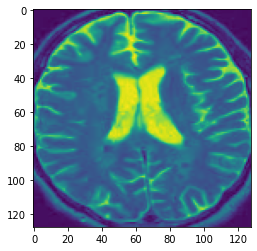

In [82]:
plt.imshow(X_train[0])

In [83]:
X_train[0].shape

(128, 128)

In [42]:
import tensorflow as tf
from tensorflow import keras


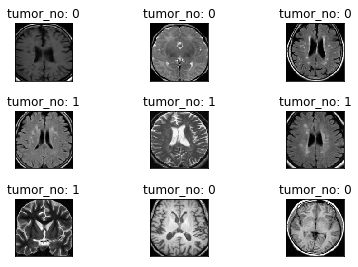

In [38]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(tumor_imgs_croped_no[i], cmap='gray', interpolation='none')
  plt.title("tumor_no: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

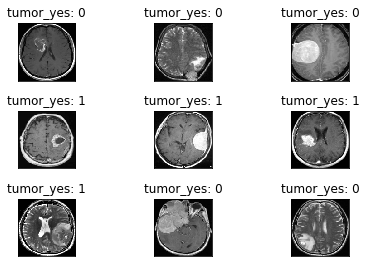

In [39]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(tumor_imgs_croped_yes[i], cmap='gray', interpolation='none')
  plt.title("tumor_yes: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [94]:
from tensorflow.keras.utils import plot_model


model = keras.models.Sequential(name='Fully_Connected')
model.add(keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255, input_shape=(128, 128)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))


model.summary()
# plot_model(model,to_file='multilayer_perceptron_graph.png')

Model: "Fully_Connected"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128)          0         
                                                                 
 flatten_7 (Flatten)         (None, 16384)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               4194560   
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dense_24 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4,260,866
Trainable params: 4,260,866
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train the model for 1 epoch from Numpy data
batch_size = 64
print("Fit on NumPy data")
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=20)

Fit on NumPy data
Epoch 1/20
4/4 [==============================] - 1s 9ms/step - loss: 17.4613 - sparse_categorical_accuracy: 0.5196
Epoch 2/20
4/4 [==============================] - 0s 10ms/step - loss: 7.3361 - sparse_categorical_accuracy: 0.4216
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 2.8728 - sparse_categorical_accuracy: 0.5245
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 1.6452 - sparse_categorical_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 0s 10ms/step - loss: 0.6030 - sparse_categorical_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 2.0111 - sparse_categorical_accuracy: 0.5294
Epoch 7/20
4/4 [==============================] - 0s 9ms/step - loss: 2.1569 - sparse_categorical_accuracy: 0.4510
Epoch 8/20
4/4 [==============================] - 0s 9ms/step - loss: 1.1934 - sparse_categorical_accuracy: 0.5000
Epoch 9/20
4/4 [==============================] - 0s 10ms/s

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 57600)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               73

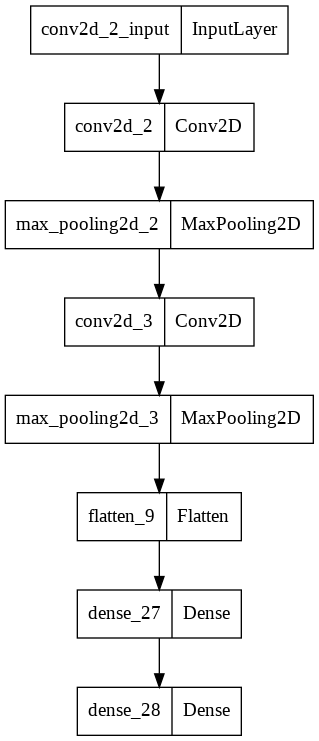

In [102]:
#define model
def get_model_cnn():
  model_cnn = tf.keras.models.Sequential(name="cnn_model")
  model_cnn.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)))
  model_cnn.add(keras.layers.MaxPooling2D(2,2))
  model_cnn.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  model_cnn.add(keras.layers.MaxPooling2D((2,2)))
  model_cnn.add(tf.keras.layers.Flatten())
  model_cnn.add(tf.keras.layers.Dense(128, activation=keras.activations.relu))
  model_cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

  model_cnn.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

  return model_cnn

model_cnn = get_model_cnn()
model_cnn.summary()
plot_model(model_cnn, to_file="model_fc.png")

In [100]:
#reshape
X_train = X_train.reshape(X_train.shape[0], 128,128,1)
X_test = X_test.reshape(X_test.shape[0], 128,128,1)
print(X_train.shape)

(204, 128, 128, 1)


In [105]:
history =model_cnn.fit(X_train, y_train, epochs=10)


Epoch 1/10
7/7 [==============================] - 0s 37ms/step - loss: 1.2472e-04 - accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 31ms/step - loss: 1.1233e-04 - accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 30ms/step - loss: 1.0215e-04 - accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 28ms/step - loss: 9.5844e-05 - accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 27ms/step - loss: 8.4871e-05 - accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 27ms/step - loss: 7.6439e-05 - accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 28ms/step - loss: 7.1744e-05 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 0s 27ms/step - loss: 6.4449e-05 - accuracy: 1.0000
Epoch 9/10
7/7 [==============================] - 0s 27ms/step - loss: 6.0839e-05 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 0s 28ms/step - loss: 5.5529e-05 - accura